<a href="https://colab.research.google.com/github/Vinsonch/CSE-676-Project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Main Code: (Start from here)**

In [ ]:
# Importing relevant libraries
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import sys
import os
import csv
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from keras.layers import Dropout

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Store all images from a directory into a Python list
def createFileList(myDir):
    fileList = []
    for root, dirs, files in os.walk(myDir, topdown=False):
        for name in files:
            fullName = os.path.join(root, name)
            fileList.append(fullName)
    return fileList

myFileList = createFileList('/content/drive/MyDrive/all_images')

#Load each image as a Pillow Image, then convert to numpy array
#Store each numpy array in a Python list
#Also store each label in a separate Python list
data = [] #Samples
labels = [] #Labels

for file in myFileList:
    name = file.split(".")
    name = name[1]
    img = Image.open(file)
    img_array = np.asarray(img)
    if img_array.shape==(200,200,3):
      data.append(img_array)
      labels.append(name)

In [ ]:
# Creating an emtpty dataframe to store labels
df=pd.DataFrame(columns=['label'])
df['label']=labels

In [ ]:
# Assigning category to labels and converting it to a numpy array
df['label'] = df['label'].replace(['threat'], 1)
df['label'] = df['label'].replace(['nonthreat'], 0)
df['label'] = df['label'].astype('int')
Y=df.to_numpy()

In [ ]:
X = np.array(data) 
#Split the image samples and labels into training and testing sets (80/20)
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Base Model

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 135424)           

In [ ]:
# Training the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 40s 114ms/step - loss: 6.5129 - accuracy: 0.8999 - val_loss: 0.0448 - val_accuracy: 0.9852
Epoch 2/10
347/347 [==============================] - 39s 111ms/step - loss: 0.0643 - accuracy: 0.9764 - val_loss: 0.0416 - val_accuracy: 0.9863
Epoch 3/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.0322 - val_accuracy: 0.9899
Epoch 4/10
347/347 [==============================] - 38s 111ms/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0.0647 - val_accuracy: 0.9827
Epoch 5/10
347/347 [==============================] - 38s 111ms/step - loss: 0.0896 - accuracy: 0.9703 - val_loss: 0.0602 - val_accuracy: 0.9748
Epoch 6/10
347/347 [==============================] - 39s 111ms/step - loss: 0.0211 - accuracy: 0.9926 - val_loss: 0.0621 - val_accuracy: 0.9773
Epoch 7/10
347/347 [==============================] - 38s 111ms/step - loss: 0.0166 - accuracy: 0.9963 - val_loss: 0.0198 - val_ac

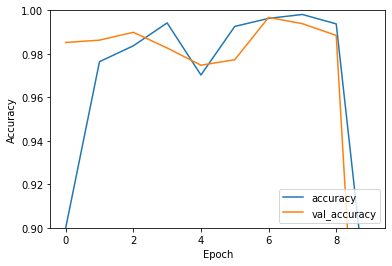

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

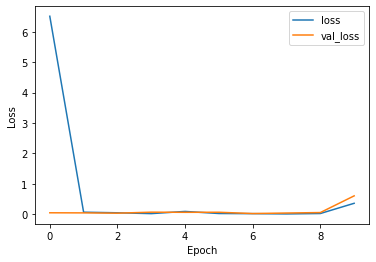

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 72.04%
Test Set Loss: 0.6


# Hyperparameter Tuning of the model.

# L1 Regularizer
## lambda = 0.01

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'valid',
        kernel_regularizer=regularizers.L1(0.01),
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 135424)           

In [ ]:
# Traning the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 40s 112ms/step - loss: 11.9156 - accuracy: 0.8588 - val_loss: 0.7290 - val_accuracy: 0.9124
Epoch 2/10
347/347 [==============================] - 38s 111ms/step - loss: 0.5298 - accuracy: 0.9603 - val_loss: 0.5610 - val_accuracy: 0.9218
Epoch 3/10
347/347 [==============================] - 38s 110ms/step - loss: 0.4250 - accuracy: 0.9775 - val_loss: 0.4813 - val_accuracy: 0.9535
Epoch 4/10
347/347 [==============================] - 38s 110ms/step - loss: 0.3800 - accuracy: 0.9825 - val_loss: 0.4423 - val_accuracy: 0.9654
Epoch 5/10
347/347 [==============================] - 39s 111ms/step - loss: 0.3124 - accuracy: 0.9950 - val_loss: 0.4809 - val_accuracy: 0.9532
Epoch 6/10
347/347 [==============================] - 38s 110ms/step - loss: 0.2872 - accuracy: 0.9973 - val_loss: 0.3881 - val_accuracy: 0.9726
Epoch 7/10
347/347 [==============================] - 38s 111ms/step - loss: 0.2945 - accuracy: 0.9932 - val_loss: 0.6237 - val_a

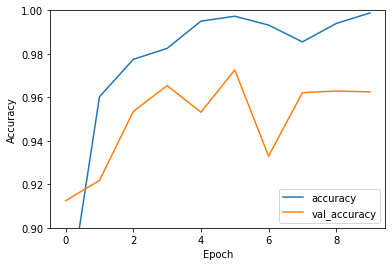

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

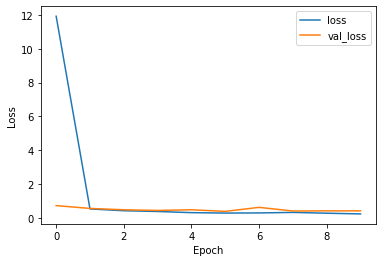

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 96.25%
Test Set Loss: 0.42


In [ ]:
# Initialize early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)


# Dropout

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 49, 49, 64)        0

In [ ]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 54s 127ms/step - loss: 10.4821 - accuracy: 0.8355 - val_loss: 0.4615 - val_accuracy: 0.8854
Epoch 2/10
347/347 [==============================] - 42s 122ms/step - loss: 0.1587 - accuracy: 0.9495 - val_loss: 0.4267 - val_accuracy: 0.8865
Epoch 3/10
347/347 [==============================] - 42s 122ms/step - loss: 0.0840 - accuracy: 0.9746 - val_loss: 0.1380 - val_accuracy: 0.9546
Epoch 4/10
347/347 [==============================] - 42s 122ms/step - loss: 0.0647 - accuracy: 0.9817 - val_loss: 0.1465 - val_accuracy: 0.9643
Epoch 5/10
347/347 [==============================] - 42s 122ms/step - loss: 0.0659 - accuracy: 0.9817 - val_loss: 0.4984 - val_accuracy: 0.8926
Epoch 6/10
347/347 [==============================] - 42s 122ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.1378 - val_accuracy: 0.9748
Epoch 7/10
347/347 [==============================] - 42s 122ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.0853 - val_a

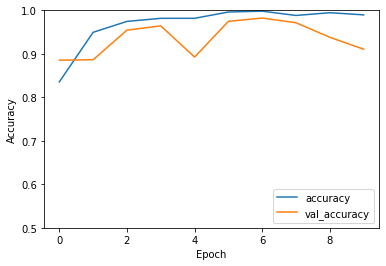

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

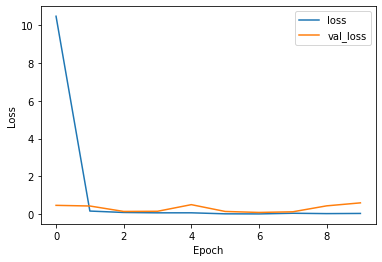

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 91.06%
Test Set Loss: 0.59


# L2 Regularizer
## lambda = 0.01

In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
        kernel_regularizer=regularizers.L2(0.01),
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 141376)           

In [ ]:
# Training the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
347/347 [==============================] - 41s 115ms/step - loss: 11.4838 - accuracy: 0.9095 - val_loss: 0.2009 - val_accuracy: 0.9409
Epoch 2/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0956 - accuracy: 0.9846 - val_loss: 0.0996 - val_accuracy: 0.9827
Epoch 3/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0891 - accuracy: 0.9877 - val_loss: 0.1292 - val_accuracy: 0.9766
Epoch 4/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0719 - accuracy: 0.9928 - val_loss: 0.0833 - val_accuracy: 0.9903
Epoch 5/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0537 - accuracy: 0.9977 - val_loss: 0.0672 - val_accuracy: 0.9942
Epoch 6/10
347/347 [==============================] - 39s 112ms/step - loss: 0.1792 - accuracy: 0.9660 - val_loss: 0.5661 - val_accuracy: 0.8670
Epoch 7/10
347/347 [==============================] - 39s 112ms/step - loss: 0.2861 - accuracy: 0.9407 - val_loss: 0.2301 - val_a

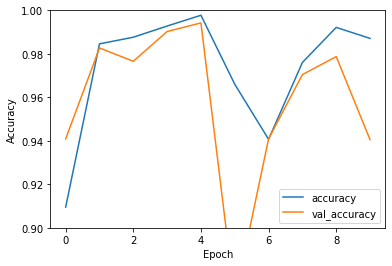

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

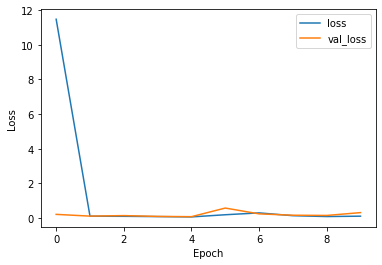

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 94.05%
Test Set Loss: 0.3


# EarlyStopping

In [ ]:
# Initializeing early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)


In [ ]:
#CNN Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',padding = 'same',
         input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 98, 98, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 47, 47, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 141376)           

In [ ]:
# Traning the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels),callbacks = [callback])

Epoch 1/10
347/347 [==============================] - 41s 114ms/step - loss: 9.8130 - accuracy: 0.8965 - val_loss: 0.1901 - val_accuracy: 0.9308
Epoch 2/10
347/347 [==============================] - 39s 112ms/step - loss: 0.1496 - accuracy: 0.9521 - val_loss: 0.1153 - val_accuracy: 0.9578
Epoch 3/10
347/347 [==============================] - 39s 113ms/step - loss: 0.1021 - accuracy: 0.9735 - val_loss: 0.0873 - val_accuracy: 0.9715
Epoch 4/10
347/347 [==============================] - 39s 113ms/step - loss: 0.0760 - accuracy: 0.9790 - val_loss: 0.1092 - val_accuracy: 0.9658
Epoch 5/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0365 - accuracy: 0.9912 - val_loss: 0.2334 - val_accuracy: 0.9427
Epoch 6/10
347/347 [==============================] - 39s 111ms/step - loss: 0.0330 - accuracy: 0.9913 - val_loss: 0.1020 - val_accuracy: 0.9751
Epoch 7/10
347/347 [==============================] - 39s 112ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.2186 - val_ac

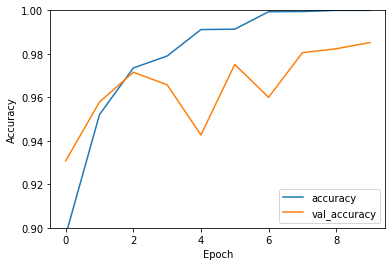

In [ ]:
#Plot for the training and validation accuracy rates
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

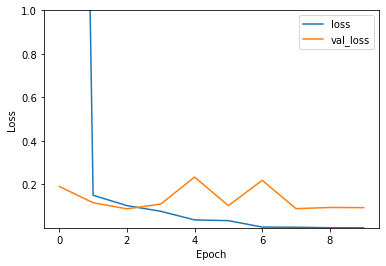

In [ ]:
#Plot for the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0001, 1])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate test error
test_error = model.evaluate(test_images, test_labels, verbose = 0)
print(f'Test Set Accuracy: {round(test_error[1] * 100, 2)}%')
print(f'Test Set Loss: {round(test_error[0], 2)}')

Test Set Accuracy: 98.52%
Test Set Loss: 0.09
